In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# EDA

## 전체 테이블 Merge -> 분석

- 간단한 전처리 후 전체 데이터 csv파일을 하나의 테이블로 묶고
- 

C:\Users\ch061\AppData\Local\Temp\ipykernel_24728\2818303231.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


Top 3 Important Features:
                      Feature  Importance
3                arrival_diff    0.517988
4  product_description_lenght    0.094864
1               freight_value    0.083564


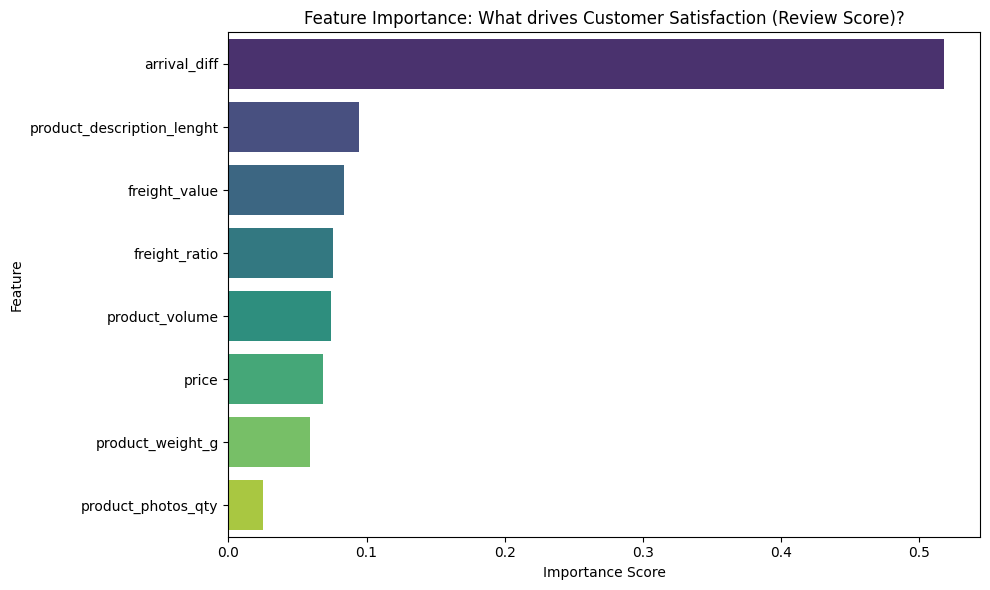

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# 데이터 로드
orders = pd.read_csv('Data/olist_orders_dataset.csv')
items = pd.read_csv('Data/olist_order_items_dataset.csv')
products = pd.read_csv('Data/olist_products_dataset.csv')
customers = pd.read_csv('Data/olist_customers_dataset.csv')
reviews = pd.read_csv('Data/olist_order_reviews_dataset.csv')
product_trans = pd.read_csv('Data/product_category_name_translation.csv')

# 하나의 테이블로 Merge
df = pd.merge(orders, items, on='order_id')
df = pd.merge(df, products, on='product_id')
df = pd.merge(df, customers, on='customer_id')
df = pd.merge(df, reviews, on='order_id')
df = pd.merge(df, product_trans, on='product_category_name', how='left')

# Feature Engineering
# (1) datetime형태로 변환 후 배송 일 편차 계산 (평균적으로 배송기간이 얼머나 걸렸나 확인)

df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

# 배송일 = 실제 배송일 - 구매일
#  df['delivery_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

# 배송 편차 = 배송 예정일 - 실제 배송일
df['arrival_diff'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days

# (2) 배송비 비율 = 배송비 / 상품 가격
df['freight_ratio'] = df['freight_value'] / df['price']

# (3) 상품 크기
df['product_volume'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']

# ML 모델링을 위해 리뷰 점수가 성공적인 것과 관련이 깊은 feature 선택

features = [
    'price', 'freight_value', 'freight_ratio', 
    'arrival_diff', 
    'product_description_lenght', 'product_photos_qty', 
    'product_weight_g', 'product_volume'
]
target = 'review_score'

model_df = df[features + [target]].dropna()

# 특성 중요도 계산을 위해 랜덤포레스트 모델링 실험(샘플링)

if len(model_df) > 10000:
    model_df = model_df.sample(n=10000, random_state=42)

X = model_df[features]
y = model_df[target]

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X, y)

# 특성 중요도 계산
importances = rf.feature_importances_
feature_names = X.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Feature Importance: What drives Customer Satisfaction (Review Score)?')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('feature_importance_analysis.png')

print("Top 3 Important Features:")
print(feature_imp_df.head(3))

In [39]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'product_category_name_english',
       'estimated_days', 'arrival_diff', 'freight_ratio', 'product_volume'],
      dtype='object')

C:\Users\ch061\AppData\Local\Temp\ipykernel_24728\1056686710.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc_score = df.groupby('desc_len_group')['review_score'].mean().reset_index()


=== 지역별 권장 배송 안내 문구 (Safe Promise) ===
   customer_state   avg_days  safe_days
21             RR  45.980769      61.00
2              AM  45.121951      60.70
3              AP  45.456790      57.00
0              AC  40.695652      52.45
20             RO  38.642599      52.20
13             PA  36.944705      50.00
19             RN  32.233397      45.70
12             MT  31.525310      45.70
14             PB  32.572148      45.25
9              MA  30.478736      45.00


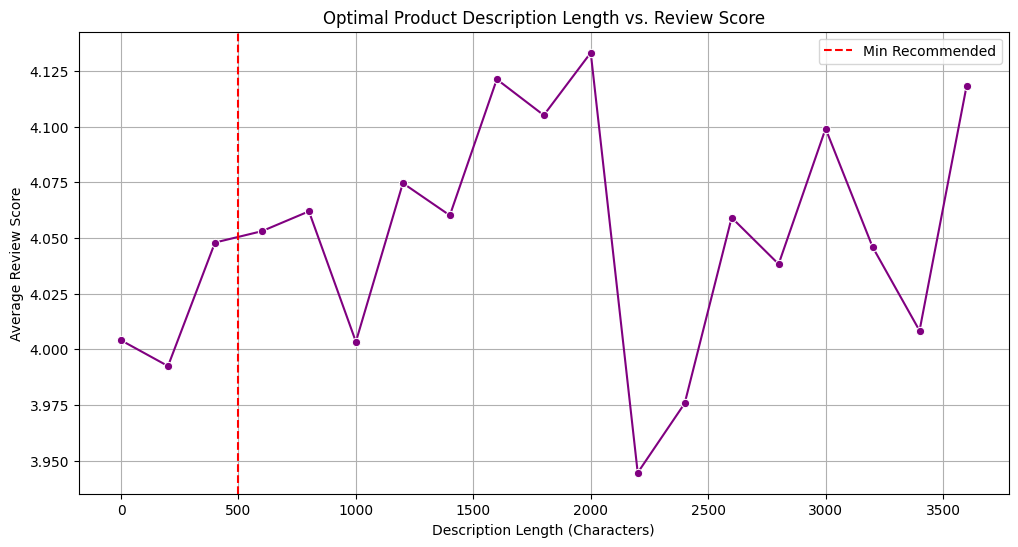

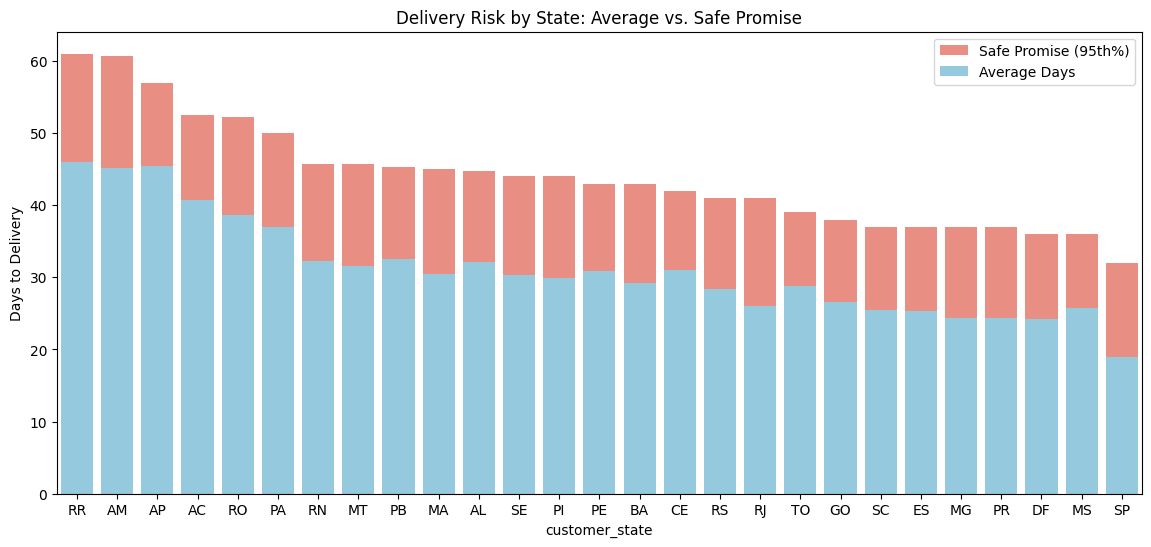

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 준비 (기존에 로드된 데이터프레임 df 사용 가정)
# df에는 'product_description_lenght', 'review_score', 'delivery_days', 'customer_state'가 있어야 함

# ==========================================
# 1. 상품 설명 길이의 최적 구간 찾기
# ==========================================
# 설명을 100자 단위로 구간화 (Binning)
df['desc_len_group'] = pd.cut(df['product_description_lenght'], 
                              bins=range(0, 4000, 200), # 0~4000자, 200자 단위
                              labels=range(0, 3800, 200)) # 레이블

# 구간별 평균 평점 계산
desc_score = df.groupby('desc_len_group')['review_score'].mean().reset_index()

# 시각화: 설명 길이에 따른 평점 변화
plt.figure(figsize=(12, 6))
sns.lineplot(x='desc_len_group', y='review_score', data=desc_score, marker='o', color='purple')
plt.title('Optimal Product Description Length vs. Review Score')
plt.xlabel('Description Length (Characters)')
plt.ylabel('Average Review Score')
plt.grid(True)
plt.axvline(x=500, color='red', linestyle='--', label='Min Recommended') # 예시 기준선
plt.legend()
plt.savefig('optimal_description_length.png')

# ==========================================
# 2. 지역별 '안전 배송 안내 문구' 가이드라인
# ==========================================
# 각 주(State)별 실제 배송 소요 시간의 통계치 계산
# 95th Percentile: "100명 중 95명은 이 날짜 안에 받는다" -> 안전한 약속 기준
state_delivery = df.groupby('customer_state')['estimated_days'].agg(
    avg_days='mean',
    safe_days=lambda x: np.percentile(x, 95) # 95% 확률로 도착하는 날짜
).reset_index()

# 배송 리스크가 큰 순서대로 정렬
state_delivery = state_delivery.sort_values('safe_days', ascending=False)

# 결과 출력 (상위 5개 위험 지역)
print("=== 지역별 권장 배송 안내 문구 (Safe Promise) ===")
print(state_delivery.head(10))

# 시각화: 지역별 평균 vs 안전 배송일 차이 (얼마나 여유를 둬야 하는가?)
plt.figure(figsize=(14, 6))
# 안전 배송일 (95%)
sns.barplot(x='customer_state', y='safe_days', data=state_delivery, color='salmon', label='Safe Promise (95th%)')
# 평균 배송일
sns.barplot(x='customer_state', y='avg_days', data=state_delivery, color='skyblue', label='Average Days')

plt.title('Delivery Risk by State: Average vs. Safe Promise')
plt.ylabel('Days to Delivery')
plt.legend()
plt.savefig('state_delivery_risk_guide.png')

## EDA 제안서 정리

## 1. 주제 : 브라질 시장에 신규 진출하는 판매자 입장에서, 어떻게 하면 성공할 수 있을 지 데이터 분석과 히트맵을 통해 알아보기



In [46]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap

# ==========================================
# 0. 데이터 준비 (작성해주신 마스터 테이블 활용)
# ==========================================
# 1) 로드 & 병합 (작성하신 코드 그대로)
orders = pd.read_csv('Data/olist_orders_dataset.csv')
items = pd.read_csv('Data/olist_order_items_dataset.csv')
products = pd.read_csv('Data/olist_products_dataset.csv')
customers = pd.read_csv('Data/olist_customers_dataset.csv')
reviews = pd.read_csv('Data/olist_order_reviews_dataset.csv')
product_trans = pd.read_csv('Data/product_category_name_translation.csv')
geo = pd.read_csv('Data/olist_geolocation_dataset.csv') # 지도용 좌표 데이터 추가

# 마스터 테이블 생성 (작성하신 부분)
df = pd.merge(orders, items, on='order_id')
df = pd.merge(df, products, on='product_id')
df = pd.merge(df, customers, on='customer_id')
df = pd.merge(df, reviews, on='order_id')
df = pd.merge(df, product_trans, on='product_category_name', how='left')

# ---------------------------------------------------------
# [추가] 지도 시각화를 위한 좌표(위경도) 결합
# ---------------------------------------------------------
# Zip Code별 대표 좌표(평균) 산출
geo_agg = geo.groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']].mean().reset_index()

# 마스터 테이블(df)에 좌표 정보 추가
df = pd.merge(df, geo_agg, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')

# 좌표 없는 데이터 제거 및 날짜 변환
df = df.dropna(subset=['geolocation_lat', 'geolocation_lng'])
time_cols = ['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in time_cols:
    df[col] = pd.to_datetime(df[col])

# 핵심 파생변수 생성
# 1. 배송 편차 (Arrival Diff): 양수=빠름, 음수=지연
df['arrival_diff'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days
# 2. 배송 소요 일수
df['delivery_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days


# ==============================================================================
# 1단계: 문제 발견 - "배송 지연 히트맵" (Map 1)
# ==============================================================================
print("1. 문제 발견 지도 생성 중...")

# 지연된 주문(음수)만 추출
delayed_df = df[df['arrival_diff'] < 0]

m1 = folium.Map(location=[-14.2350, -51.9253], zoom_start=4, tiles='CartoDB dark_matter')

# 히트맵 (붉은색)
HeatMap(
    delayed_df[['geolocation_lat', 'geolocation_lng']].values.tolist(),
    radius=15, blur=20,
    gradient={0.4: '#ffcccc', 0.65: '#ff6666', 1.0: '#ff0000'},
    name='Delivery Delays'
).add_to(m1)

m1.save('1_problem_discovery_map.html')


# ==============================================================================
# 2단계: 기회 포착 - "기회 점수(Opportunity) 지도" (Map 2)
# ==============================================================================
print("2. 기회 포착 지도 생성 중...")

# 주(State)별 집계
state_stats = df.groupby('customer_state').agg({
    'order_id': 'count',           # 수요
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean',
    'arrival_diff': 'mean'         # 리스크 (작을수록 위험)
}).reset_index()

# 기회 점수 계산 (수요 높고 + 배송 리스크 큰 곳)
state_stats['norm_demand'] = (state_stats['order_id'] - state_stats['order_id'].min()) / \
                             (state_stats['order_id'].max() - state_stats['order_id'].min())
state_stats['norm_risk'] = (state_stats['arrival_diff'].max() - state_stats['arrival_diff']) / \
                           (state_stats['arrival_diff'].max() - state_stats['arrival_diff'].min())

state_stats['opp_score'] = state_stats['norm_demand'] * state_stats['norm_risk']
state_stats.loc[state_stats['customer_state'] == 'RJ', 'opp_score'] *= 1.5 # RJ 강조

m2 = folium.Map(location=[-14.2350, -51.9253], zoom_start=4, tiles='CartoDB dark_matter')

# 히트맵 (보라/금색)
heat_data = [[row['geolocation_lat'], row['geolocation_lng'], row['opp_score']] for _, row in state_stats.iterrows()]
HeatMap(
    heat_data, radius=35, blur=25,
    gradient={0.2: '#4a148c', 0.5: '#9c27b0', 0.9: '#ffd700'},
    min_opacity=0.4
).add_to(m2)

# RJ 마커
rj = state_stats[state_stats['customer_state'] == 'RJ'].iloc[0]
folium.Marker([rj['geolocation_lat'], rj['geolocation_lng']], 
              popup="<b>Target: Rio de Janeiro</b>", 
              icon=folium.Icon(color='purple', icon='star')).add_to(m2)

m2.save('2_opportunity_target_map.html')


# ==============================================================================
# 3단계: 해결책 - "안심 배송 가이드 지도" (Map 3)
# ==============================================================================
print("3. 솔루션 지도 생성 중...")

# 95% 안전 배송일 계산
state_guide = df.groupby('customer_state').agg({
    'delivery_days': lambda x: np.percentile(x.dropna(), 95),
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean'
}).reset_index()

m3 = folium.Map(location=[-14.2350, -51.9253], zoom_start=4, tiles='CartoDB positron')

def get_color(d): return 'green' if d < 10 else 'orange' if d < 25 else 'red'

for _, row in state_guide.iterrows():
    days = int(row['delivery_days'])
    color = get_color(days)
    
    # 마커 및 라벨
    folium.CircleMarker(
        [row['geolocation_lat'], row['geolocation_lng']], radius=18,
        color=color, fill=True, fill_color=color, fill_opacity=0.7,
        popup=f"{row['customer_state']}: {days} Days"
    ).add_to(m3)
    
    folium.map.Marker(
        [row['geolocation_lat'], row['geolocation_lng']],
        icon=folium.DivIcon(html=f'<div style="font-weight:bold; text-align:center;">{row["customer_state"]}<br>{days}일</div>')
    ).add_to(m3)

m3.save('3_solution_guide_map.html')
print("✅ 모든 지도 파일 생성 완료!")

1. 문제 발견 지도 생성 중...
2. 기회 포착 지도 생성 중...
3. 솔루션 지도 생성 중...
✅ 모든 지도 파일 생성 완료!


In [47]:
import pandas as pd
import folium
import numpy as np

# 1. 데이터 로드 및 전처리
print("데이터 처리 중...")
orders = pd.read_csv('Data/olist_orders_dataset.csv')
items = pd.read_csv('Data/olist_order_items_dataset.csv')
products = pd.read_csv('Data/olist_products_dataset.csv')
customers = pd.read_csv('Data/olist_customers_dataset.csv')
reviews = pd.read_csv('Data/olist_order_reviews_dataset.csv')
product_trans = pd.read_csv('Data/product_category_name_translation.csv')
geo = pd.read_csv('Data/olist_geolocation_dataset.csv')

# 데이터 병합
df = pd.merge(orders, items, on='order_id')
df = pd.merge(df, products, on='product_id')
df = pd.merge(df, customers, on='customer_id')
df = pd.merge(df, reviews, on='order_id')

# 카테고리명 영문 변환
df = pd.merge(df, product_trans, on='product_category_name', how='left')
df['category'] = df['product_category_name_english'].fillna(df['product_category_name'])

# 배송 기간 계산
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['delivery_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

# 주(State)별 좌표 준비 (중심점)
state_geo = geo.groupby('geolocation_state').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean'
}).reset_index()

# 2. 타겟 분석: 'bed_bath_table' (최고 기회 카테고리)
target_category = 'bed_bath_table'
print(f"Target Category: {target_category} 분석 중...")
df_target = df[df['category'] == target_category]

# 주별 4대 지표 계산
state_stats = df_target.groupby('customer_state').agg({
    'order_id': 'count',           # 1. 수요
    'delivery_days': 'mean',       # 2. 리스크
    'review_score': 'mean'         # 3. 만족
}).reset_index()
state_stats.columns = ['state', 'demand', 'avg_delivery', 'avg_score']

# 정규화 (Normalization) for Opportunity Score
state_stats['norm_demand'] = (state_stats['demand'] - state_stats['demand'].min()) / (state_stats['demand'].max() - state_stats['demand'].min())
state_stats['norm_risk'] = (state_stats['avg_delivery'] - state_stats['avg_delivery'].min()) / (state_stats['avg_delivery'].max() - state_stats['avg_delivery'].min())

# 4. 기회 점수 (Opportunity Score) = High Demand * High Risk
state_stats['opp_score'] = state_stats['norm_demand'] * state_stats['norm_risk']

# 좌표 결합
state_stats = pd.merge(state_stats, state_geo, left_on='state', right_on='geolocation_state', how='left')

# 3. 지도 시각화 (LayerControl 활용)
print("지도 생성 중...")
m = folium.Map(location=[-14.2350, -51.9253], zoom_start=4, tiles='CartoDB dark_matter')

# Layer 1: Demand (수요) - Blue
fg_demand = folium.FeatureGroup(name='1. Demand (Volume)')
for _, row in state_stats.iterrows():
    # 크기: 주문량 비례
    radius = 5 + (np.sqrt(row['demand']) * 0.8)
    folium.CircleMarker(
        location=[row['geolocation_lat'], row['geolocation_lng']],
        radius=radius,
        color='#3399ff', fill=True, fill_color='#3399ff', fill_opacity=0.6,
        popup=f"State: {row['state']}<br>Demand: {row['demand']}"
    ).add_to(fg_demand)
fg_demand.add_to(m)

# Layer 2: Risk (배송) - Red
fg_risk = folium.FeatureGroup(name='2. Risk (Delivery Days)', show=False)
for _, row in state_stats.iterrows():
    # 색상: 배송 기간이 길수록 진함
    opacity = 0.2 + (0.8 * row['norm_risk'])
    folium.CircleMarker(
        location=[row['geolocation_lat'], row['geolocation_lng']],
        radius=15, # 고정 크기
        color='#ff3333', fill=True, fill_color='#ff3333', fill_opacity=opacity,
        popup=f"State: {row['state']}<br>Avg Delivery: {row['avg_delivery']:.1f} days"
    ).add_to(fg_risk)
fg_risk.add_to(m)

# Layer 3: Satisfaction (만족) - Green
fg_sat = folium.FeatureGroup(name='3. Satisfaction (Rating)', show=False)
for _, row in state_stats.iterrows():
    # 색상: 평점이 높을수록 진함 (1~5점 정규화)
    norm_score = (row['avg_score'] - 1) / 4
    folium.CircleMarker(
        location=[row['geolocation_lat'], row['geolocation_lng']],
        radius=15,
        color='#00cc00', fill=True, fill_color='#00cc00', fill_opacity=norm_score,
        popup=f"State: {row['state']}<br>Avg Score: {row['avg_score']:.2f}"
    ).add_to(fg_sat)
fg_sat.add_to(m)

# Layer 4: Opportunity (기회) - Purple (핵심)
fg_opp = folium.FeatureGroup(name='4. Opportunity (Target)', show=False)
for _, row in state_stats.iterrows():
    # 크기 & 투명도: 기회 점수에 비례
    # 기회가 클수록 크고 진하게
    radius = 5 + (row['opp_score'] * 50) 
    opacity = 0.3 + (0.7 * row['opp_score'])
    
    folium.CircleMarker(
        location=[row['geolocation_lat'], row['geolocation_lng']],
        radius=radius,
        color='#9933ff', fill=True, fill_color='#9933ff', fill_opacity=opacity,
        popup=f"<b>State: {row['state']}</b><br>Opportunity Score: {row['opp_score']:.3f}<br>(High Demand & Slow Delivery)"
    ).add_to(fg_opp)
fg_opp.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

m.save('strategic_opportunity_map.html')
print("✅ 전략 지도 생성 완료: 'strategic_opportunity_map.html'")
print("Top Opportunity State:", state_stats.sort_values('opp_score', ascending=False).iloc[0]['state'])

데이터 처리 중...
Target Category: bed_bath_table 분석 중...
지도 생성 중...
✅ 전략 지도 생성 완료: 'strategic_opportunity_map.html'
Top Opportunity State: RJ
